#Libs

In [1]:
!pip install polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 33.8 MB/s eta 0:00:00


In [2]:
import polars as pl
import gzip
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np

In [3]:
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(None)

polars.config.Config

#Data Load

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
columns = ['ServerTimestamp [epoch]',
           'MarketTimestamp [epoch]',
           'ServerTimestamp [datatime, us]',
           'MarketTimestamp [datatime,us]',
           'Mdtype',
           '[price;qty;nborders] ask 0',
           '[price;qty;nborders] ask 1',
           '[price;qty;nborders] ask 2',
           '[price;qty;nborders] ask 3',
           '[price;qty;nborders] ask 4',
           '[price;qty;nborders] ask 5',
           '[price;qty;nborders] ask 6',
           '[price;qty;nborders] ask 7',
           '[price;qty;nborders] ask 8',
           '[price;qty;nborders] ask 9',
           'M',
           '[price;qty;nborders] bid 0',
           '[price;qty;nborders] bid 1',
           '[price;qty;nborders] bid 2',
           '[price;qty;nborders] bid 3',
           '[price;qty;nborders] bid 4',
           '[price;qty;nborders] bid 5',
           '[price;qty;nborders] bid 6',
           '[price;qty;nborders] bid 7',
           '[price;qty;nborders] bid 8',
           '[price;qty;nborders] bid 9',
           'Obflag',
           'ftflagMSBid ',
           'ftflagMSAsk ',
           'ftflagTLSell ',
           'ftflagTLBuy ',
           'Stream ',
           'Revision ']

In [6]:
start = time.time()

file_path = "/content/drive/MyDrive/Quant/dataset_test/Local#FAST_CURR_MD#MOEX_CURR#CETS#USDCNY_TOM.2023-08-14.gz"

with gzip.open(file_path, 'rt') as f:
    df = pl.read_csv(f, has_header=False, new_columns=columns)

end = time.time()

In [7]:
end - start

21.60797882080078

# Part 1

## Frequency

In [8]:
start = time.time()

In [9]:
Frequency_data = df.filter((pl.col('Mdtype') == 0) | (pl.col('Mdtype') == 2)).select(['ServerTimestamp [datatime, us]', 'Stream '])

Frequency_data = Frequency_data.with_columns(
    pl.col('ServerTimestamp [datatime, us]').str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M:%S%.f')
)

Frequency_data = Frequency_data.sort('ServerTimestamp [datatime, us]').with_columns(
    (pl.col('ServerTimestamp [datatime, us]').cast(pl.Int64) - pl.col('ServerTimestamp [datatime, us]').shift(1).cast(pl.Int64)).alias('TimeDiff')
)

# Convert TimeDiff from nanoseconds to seconds
Frequency_data = Frequency_data.with_columns(
    (pl.col('TimeDiff') / 1_000_000_000).alias('TimeDiff')
)

Frequency_data = (
    Frequency_data
    .filter(pl.col('TimeDiff') != 0)
    .drop_nulls()
)

In [10]:
Frequency_data = Frequency_data.with_columns([
    pl.col('ServerTimestamp [datatime, us]').dt.hour().alias('Hour'),
    pl.col('ServerTimestamp [datatime, us]').dt.minute().alias('Minute'),
    pl.col('ServerTimestamp [datatime, us]').dt.second().alias('Second')
])

In [11]:
start_time = datetime.strptime('10:00:00', '%H:%M:%S').time()
end_time = datetime.strptime('18:40:00', '%H:%M:%S').time()
filtered_data = Frequency_data.filter(
    (pl.col('ServerTimestamp [datatime, us]').dt.time() >= start_time) &
    (pl.col('ServerTimestamp [datatime, us]').dt.time() <= end_time)
)

frequency = filtered_data.group_by(['Hour', 'Minute', 'Second']).agg(
    pl.len().alias('count')
)

frequency = frequency.sort(by=['Hour', 'Minute', 'Second'])

frequency = frequency.with_columns([
    pl.concat_str([
        pl.col('Hour').cast(pl.Utf8),
        pl.lit(':'),
        pl.col('Minute').cast(pl.Utf8).str.zfill(2),
        pl.lit(':'),
        pl.col('Second').cast(pl.Utf8).str.zfill(2)
    ]).alias('Time')
])

In [12]:
def create_time_range(start_time, end_time, interval_minutes):
    start_dt = datetime.strptime(start_time, '%H:%M:%S')
    end_dt = datetime.strptime(end_time, '%H:%M:%S')
    interval = timedelta(minutes=interval_minutes)
    current_time = start_dt
    times = []
    while current_time <= end_dt:
        times.append(current_time.strftime('%H:%M:%S'))
        current_time += interval
    return times

In [13]:
start_str = '10:00:00'
end_str = '18:40:00'
interval = 20

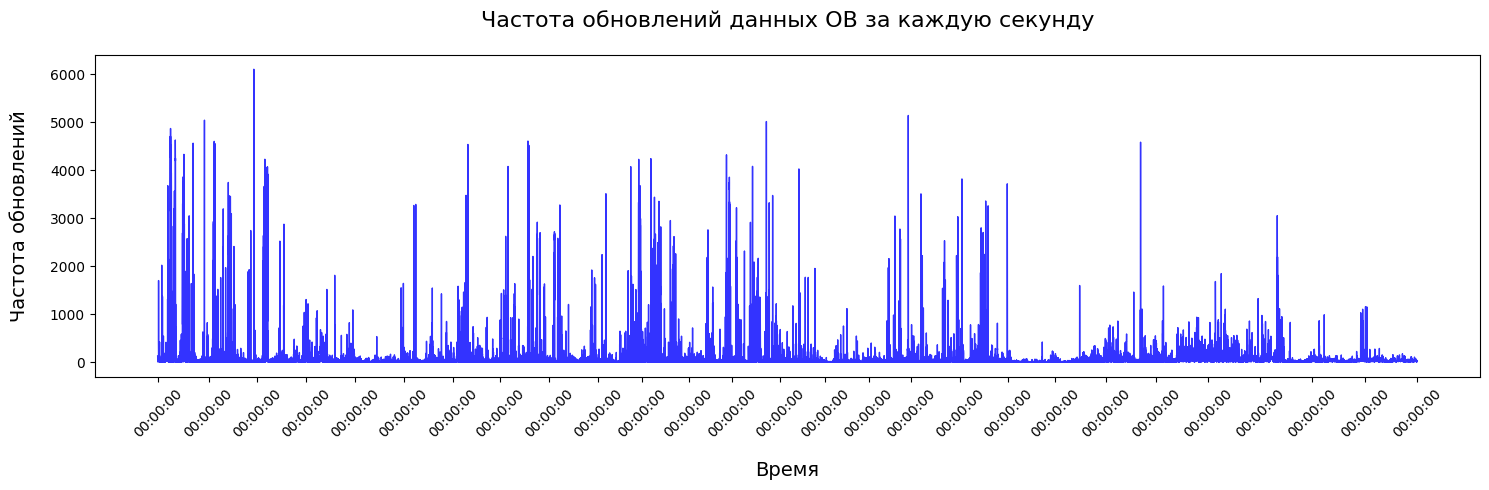

In [14]:
start_str = '10:00:00'
end_str = '18:40:00'
interval = 20

tick_positions = create_time_range(start_str, end_str, interval)

plt.figure(figsize=(15, 5))
plt.plot(frequency.select('Time').to_numpy().flatten(), frequency.select('count').to_numpy().flatten(), color='blue', linewidth=1, linestyle='-', alpha=0.8)
plt.title('Частота обновлений данных ОВ за каждую секунду', fontsize=16, pad=20)
plt.xlabel('Время', fontsize=14, labelpad=15)
plt.ylabel('Частота обновлений', fontsize=14, labelpad=15)

# Set custom x-axis formatter to display only HH:MM:SS
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
# Manually set x-axis ticks
plt.gca().set_xticks(tick_positions)

plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
end = time.time()

In [16]:
end - start

4.9455859661102295

## Distance

n% переданной информации = $(1 - \frac{n}{100})$ квантиль времени обновления / 2 (в сторону получателя и обратно):

#### Оценка расстояния от сервера Московской биржи до аккаунта пользователя.

Для оценки расстояния от сервера Московской биржи до аккаунта пользователя можно использовать информацию о времени задержки передачи данных (RTT) и скорости света в оптическом волокне. Сигналы в оптическом волокне распространяются со скоростью, которая составляет примерно $\frac{2}{3}$ от скорости света в вакууме.

#### Данные для расчета:
- **Время туда и обратно (RTT):** 7 микросекунд (мкс)
- **Скорость света в вакууме:** \($c = 3 \times 10^8$\) м/с
- **Коэффициент преломления оптического волокна:** \($n \approx 1.5$\) что означает, что скорость света в оптическом волокне составляет $\frac{c}{1.5}$

#### Шаги для расчета:

1. **Определяем скорость света в оптическом волокне:**
   \begin{align}
   c_{\text{волокно}} = \frac{3 \times 10^8\ \text{м/с}}{1.5} = 2 \times 10^8\ \text{м/с}
   \end{align}

2. **Время передачи сигнала в одну сторону:**
   \begin{align}
   t_{\text{один путь}} = \frac{7 \times 10^{-6}\ \text{сек}}{2} = 3.5 \times 10^{-6}\ \text{сек}
   \end{align}

3. **Расчет расстояния:**
   \begin{align}
   d = t_{\text{один путь}} \times c_{\text{волокно}} = 700\ \text{м}
   \end{align}



In [84]:
start = time.time()

In [85]:
start = time.time()
# Calculation of quantile values from 0.01 to 0.99
quantiles = np.linspace(0.01, 0.99, 99)

time_quantiles = (
    Frequency_data
    .with_columns(
        pl.col("TimeDiff").qcut(
            quantiles,
            labels=[f'{i}' for i in range(1, 101)],
            allow_duplicates=True,
            include_breaks=True
        ).alias("quantile_bin")
    )
    .select("quantile_bin")
    .unnest("quantile_bin")
    .filter(pl.col("breakpoint") != float('inf'))
    .select("breakpoint")
    .unique()
).to_numpy().flatten() / 2

time_quantiles = np.sort(time_quantiles)

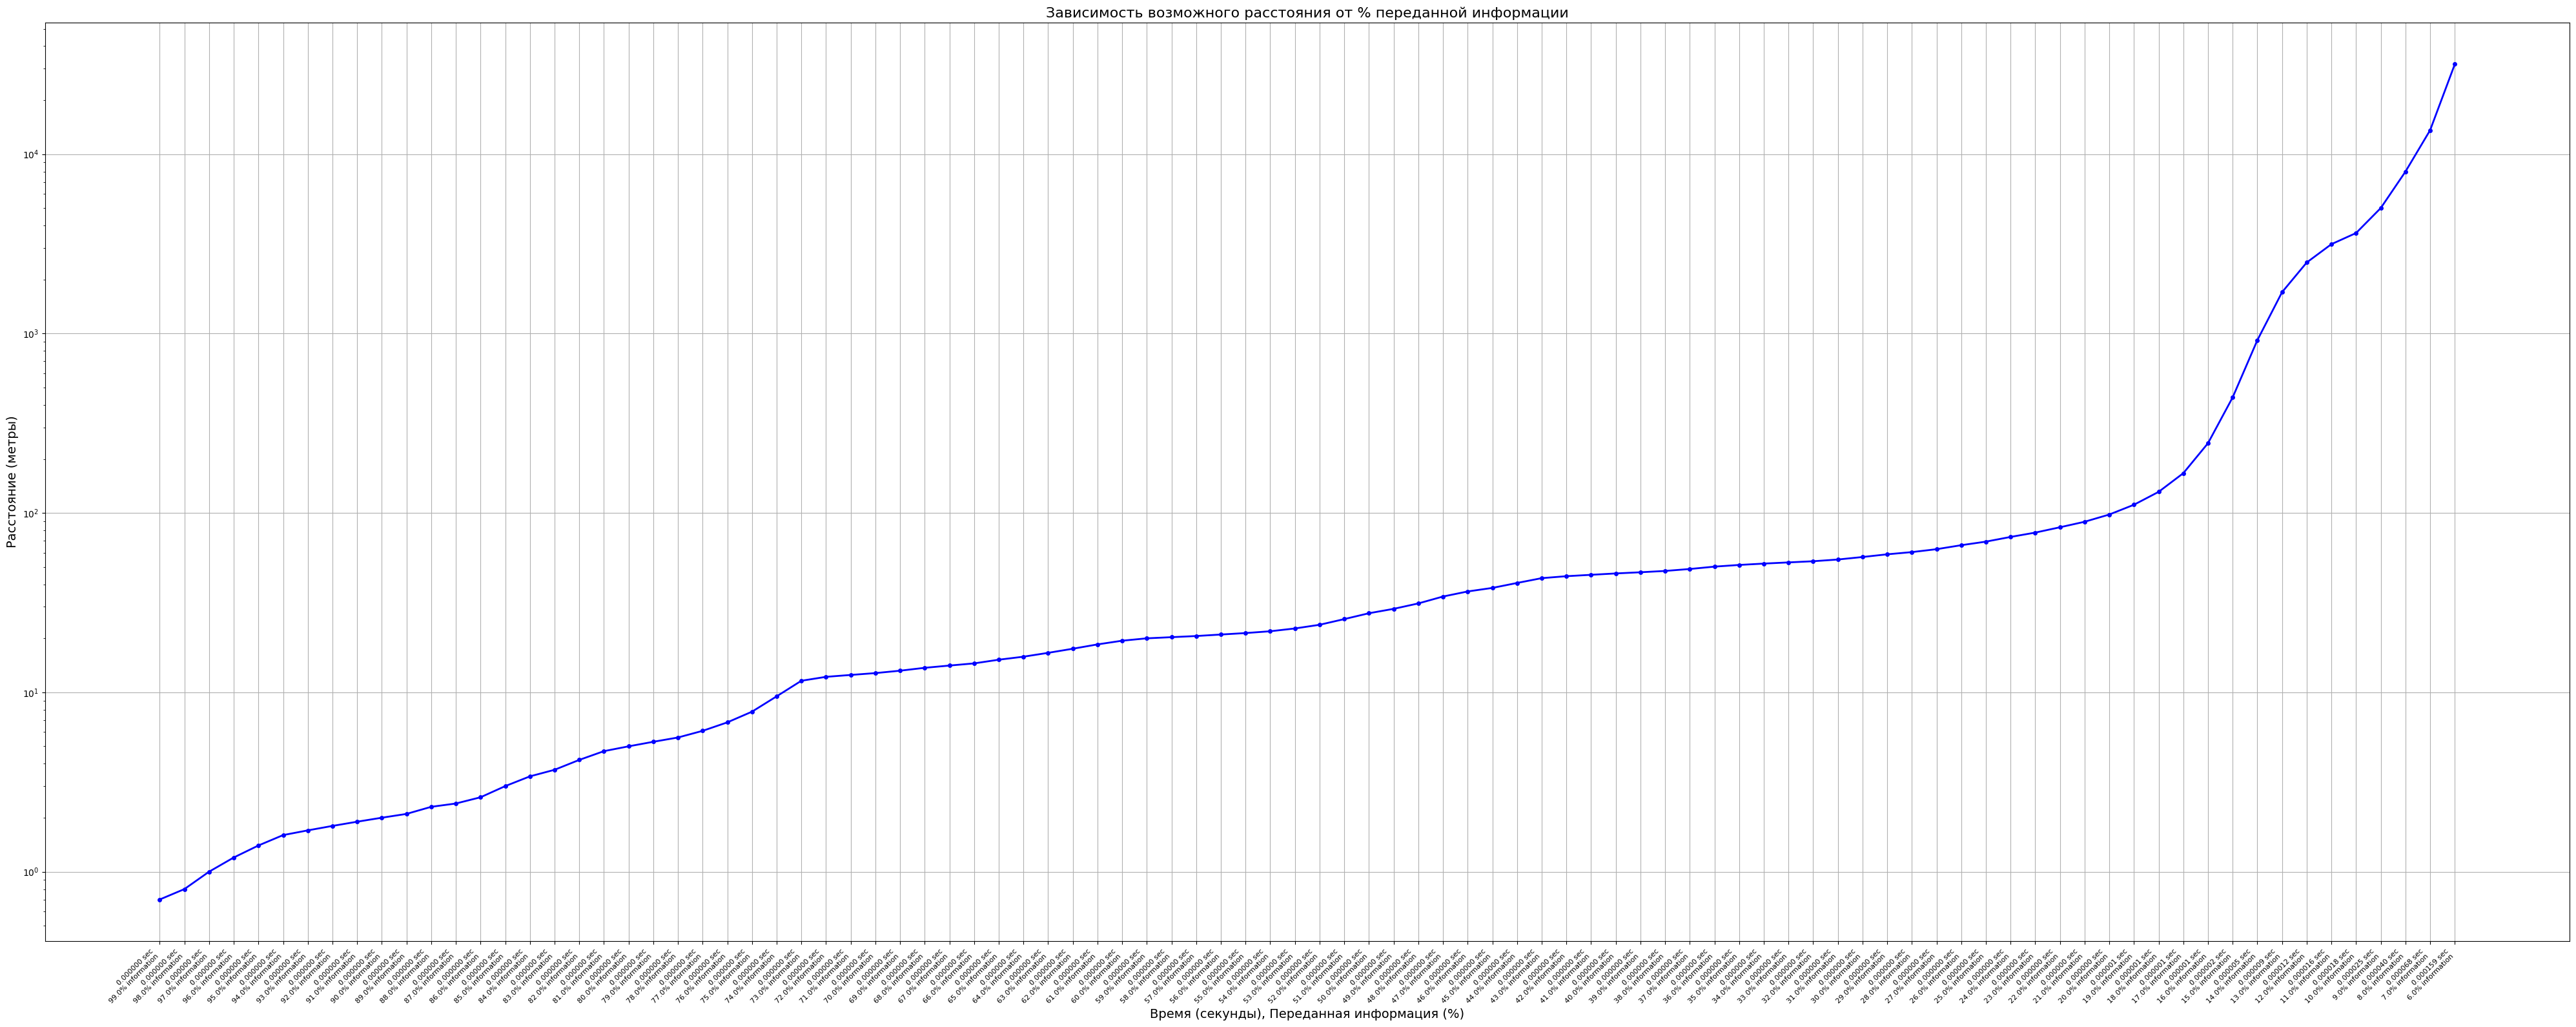

In [86]:
c = 3 * 10**8  # speed of light in a vacuum (m/s)
n = 1.5  # refractive index of optical fiber
c_fiber = c / n  # speed of light in optical fiber (m/s)

distance_quantiles = np.array(time_quantiles) * c_fiber

loss_percent = 100 * (1 - quantiles)

x_labels = [f"{t:.6f} sec\n{loss:.1f}% information" for t, loss in zip(time_quantiles, loss_percent)]

plt.figure(figsize=(40, 16))
plt.plot(range(len(time_quantiles)), distance_quantiles, marker='o', color='blue', linewidth=2, markersize=4)
plt.title('Зависимость возможного расстояния от % переданной информации', fontsize=16)
plt.xlabel('Время (секунды), Переданная информация (%)', fontsize=14)
plt.ylabel('Расстояние (метры)', fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.xticks(ticks=range(len(time_quantiles)), labels=x_labels, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

In [87]:
end = time.time()

In [88]:
end - start

1.7637832164764404

#Part 2

In [ ]:
start = time.time()

In [ ]:
data = df.filter(pl.col('Mdtype') == 1)

data = data.with_columns(
    pl.col('ServerTimestamp [datatime, us]').str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M:%S%.f')
)

start_time = datetime.strptime('10:00:00', '%H:%M:%S').time()
end_time = datetime.strptime('18:40:00', '%H:%M:%S').time()

filtered_data = data.filter(
    (pl.col('ServerTimestamp [datatime, us]').dt.time() >= start_time) &
    (pl.col('ServerTimestamp [datatime, us]').dt.time() <= end_time)
)

In [ ]:
filtered_data = filtered_data.with_columns([
    pl.col('[price;qty;nborders] ask 3').cast(pl.Int32)
])

filtered_data = filtered_data.with_columns([
    pl.when(pl.col('[price;qty;nborders] ask 3') == 1)
      .then(pl.lit('buy'))
      .otherwise(pl.lit('sell'))
      .alias('side')
])

In [ ]:
filtered_data = filtered_data.with_columns([
    (pl.col('MarketTimestamp [epoch]').shift(1) != pl.col('MarketTimestamp [epoch]'))
    .or_(
        pl.col('side').shift(1) != pl.col('side')
    ).cum_sum()
    .alias('TradeID')
])

filtered_data = filtered_data.with_columns([
    pl.col('[price;qty;nborders] ask 0').cast(pl.Float64).alias('Qty')
])

trade_sizes = filtered_data.group_by('TradeID').agg([
    pl.col('Qty').sum().alias('TotalQty')
])

In [ ]:
# Calculate statistics
mean_qty = trade_sizes['TotalQty'].mean()
stddev_qty = trade_sizes['TotalQty'].std()
median_qty = trade_sizes['TotalQty'].median()

percentiles = [0.6, 0.7, 0.8, 0.9]
quantiles = [trade_sizes.select(pl.col('TotalQty').quantile(p)).to_numpy()[0] for p in percentiles]

percentile_pairs = [(f"{int(p*100)}%", int(v)) for p, v in zip(percentiles, quantiles)]

print("Mean:", mean_qty)
print("StdDev:", stddev_qty)
print("Median:", median_qty)
print("\nPercentiles.")
for percentile, value in percentile_pairs:
    print(f"  {percentile}: {value}")

Mean: 96.8765243902439
StdDev: 169.76472580726883
Median: 50.0

Percentiles.
  60%: 66
  70%: 100
  80%: 100
  90%: 150


<ipython-input-178-ad093ed882a1>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  percentile_pairs = [(f"{int(p*100)}%", int(v)) for p, v in zip(percentiles, quantiles)]


In [ ]:
def calculate_probabilities(filtered_data: pl.DataFrame, trade_sizes: pl.DataFrame, threshold: float) -> float:
    # Filter trades by quantity threshold
    mask = trade_sizes.filter(pl.col('TotalQty') >= threshold)

    # Filter the original data by TradeID
    filtered = filtered_data.filter(pl.col('TradeID').is_in(mask['TradeID']))

    # Add columns for previous side and match status
    filtered = filtered.with_columns([
        pl.col('side').shift(1).alias('prev_side')
    ])
    filtered = filtered.with_columns([
        (pl.col('side') == pl.col('prev_side')).alias('side_match')
    ])

    # Calculate the number of matches and total trades
    matching_sides = filtered.select(pl.col('side_match').sum()).to_numpy()[0][0]
    total_trades = filtered.height

    # Calculate the probability
    probability = matching_sides / total_trades if total_trades > 0 else 0

    return probability

In [ ]:
# Calculate probabilities
prob_mean = calculate_probabilities(filtered_data, trade_sizes, mean_qty)
prob_median = calculate_probabilities(filtered_data, trade_sizes, median_qty)
prob_mean_plus_stddev = calculate_probabilities(filtered_data, trade_sizes, mean_qty + stddev_qty)

print(f"Probability(Qty >= mean): {prob_mean:.4f}")
print(f"Probability(Qty >= median): {prob_median:.4f}")
print(f"Probability(Qty >= mean + stddev): {prob_mean_plus_stddev:.4f}")

Probability(Qty >= mean): 0.8653
Probability(Qty >= median): 0.8364
Probability(Qty >= mean + stddev): 0.9363


In [ ]:
end = time.time()

In [ ]:
end - start

0.42974066734313965